# Project 2 – Integer Programming: Optimization I
## Index Tracking
Date: November 4th, 2022
### Group members:
+ Nicolay Huarancay: nh23865
+ Aishwarya Sarkar: as99646
+ Benjamin Kanarick: bjk2437
+ Rochan Nehete: rrn479
***

#### Modules

In [1]:
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

## Setting: Time Limit --This number should be set!!

In [2]:
# TIME LIMIT
time_limit = 20

## List of m's - description

For a number of $n$ stocks. We create a list "**lst_ms**" with the logic:
+ First element = 5
+ Multiples of (step=10) from step to <= n. range(step,n,step)
+ Last element = n


```{python}
lst_ms = [5] + [*range(step,n_stocks,step)] + [n_stocks] # The list depends on number of stocks and the step
```


In [3]:
# Hard coding: List of m's
n_stocks = 100
step = 10
lst_ms = [5] + [*range(step,n_stocks,step)] + [n_stocks] # The list depends on number of stocks and the step
lst_ms

[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### Data

In [4]:
df_stocks_train = pd.read_csv('stocks2019.csv') # Train
df_stocks_oos = pd.read_csv('stocks2020.csv')   # Out of Sample

### Setting: Date and Index column names
Please edit the names of the columns (Date Column and Index Column )

In [5]:
# Colum names
col_date_name = 'X'
col_index_name = 'NDX'

#-------------------------------------------------------
lst_drop = list([col_date_name,col_index_name])

In [6]:
# Returns
#---------------------------------------------------------------------------
# Train - 2019
df_returns_train = df_stocks_train.drop(lst_drop, axis=1).pct_change().dropna() # Returns all
q = df_stocks_train[col_index_name].pct_change().dropna()

# Out of Sample - 2020
df_returns_oos = df_stocks_oos.drop(lst_drop, axis=1).pct_change().dropna()
q_oos = df_stocks_oos[col_index_name].pct_change().dropna()

# Correlation Matrix
#---------------------------------------------------------------------------
df_abs_corr_matrix = df_returns_train.corr()

In [7]:
# Train - 2019
#------------------------------------------------------
# Number of Stocks
n_stocks = len(df_abs_corr_matrix)

# List of Stocks
lst_stocks = df_abs_corr_matrix.columns.tolist()

# Dictionaries of Correlation Matrix and Returns
p = df_abs_corr_matrix.to_dict()
r = df_returns_train.to_dict()

# Dates range
lst_dindex = q.index.values.tolist()

# Out of Sample - 2020
#------------------------------------------------------
# Dictionaries
r_oos = df_returns_oos.to_dict()

# Dates range
lst_dindex_oos = q_oos.index.values.tolist()

# Question 2

### Stock Selection
with m = 5

In [8]:
def stock_selection(m):
    #-------------------------------------------------------------------------
    ## STOCK SELECTION
    #-------------------------------------------------------------------------
    # Model
    mod = gp.Model()
    mod.ModelSense = GRB.MAXIMIZE

    # Decision Variables
    x = mod.addVars(lst_stocks,lst_stocks,vtype=GRB.BINARY,name='x') 
    y = mod.addVars(lst_stocks,vtype=GRB.BINARY,name='y') 

    # First Constraints
    mod.addConstr( sum(y[i] for i in lst_stocks) == m, "m")

    # Second constrint
    for i in lst_stocks:
        mod.addConstr( sum(x[i,j] for j in lst_stocks) == 1, "Mapping")

    # Third constraint
    mod.addConstrs( (x[i,j] <= y[j] for i in lst_stocks for j in lst_stocks), "Presence")

    # Objective Function
    mod.setObjective( sum(p[i][j]*x[i,j] for i in lst_stocks for j in lst_stocks))

    mod.Params.OutputFlag = 0
    # Solve
    mod.optimize()
    
    # Output Stocks
    lst_x_output = []
    for i in lst_stocks:
        for j in lst_stocks:
            if x[i,j].X == 1 and j not in lst_x_output:
                lst_x_output.append(j)
                
    return mod, lst_x_output

In [9]:
# Running Stock Selection
mod, lst_x_output = stock_selection(m=5)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


In [10]:
# Objective Value
mod.objVal

54.83990652229107

In [11]:
# Stocks Selected
lst_x_output

['MSFT', 'VRTX', 'MXIM', 'LBTYK', 'XEL']

### Portfolio Weights
with m = 5

In [12]:
def portfolio_weights(m,lst_x_output):
    #-------------------------------------------------------------------------
    ## PORTFOLIO WEIGHTS
    #-------------------------------------------------------------------------
    # Model
    w_mod = gp.Model()
    w_mod.ModelSense = GRB.MINIMIZE

    # Decision Variables
    w = w_mod.addVars(lst_x_output,vtype=GRB.CONTINUOUS,ub=[1]*len(lst_x_output),name='w')
    u = w_mod.addVars(lst_dindex,vtype=GRB.CONTINUOUS,name='u')

    # Constraints
    w_mod.addConstr( sum(w[i] for i in lst_x_output) == 1, "sum_w") #addition of weights should be 1
    w_mod.addConstrs( (u[j] >=  (q[j] - sum(w[i]*r[i][j] for i in lst_x_output))  for j in lst_dindex), "abs_value_1" ) #1st constraint for absolute function for u
    w_mod.addConstrs( (u[j] >= -(q[j] - sum(w[i]*r[i][j] for i in lst_x_output))  for j in lst_dindex), "abs_value_2" ) #2nd constraint for absolute function for u

    # Objective Function
    w_mod.setObjective( sum(u[j] for j in lst_dindex) )

    w_mod.Params.OutputFlag = 0
    w_mod.Params.TIME_LIMIT = time_limit
    # Solve
    w_mod.optimize()        

    # Performance
    # Calculating returns
    # 2019
    mod_ret = pd.Series(index=lst_dindex, dtype=float)
    for j in lst_dindex:
        mod_ret.loc[j] = sum(w[i].X*r[i][j] for i in lst_x_output)   
        
    # 2020
    mod_ret_oos = pd.Series(index=lst_dindex_oos, dtype=float)
    for j in lst_dindex_oos:
        mod_ret_oos.loc[j] = sum(w[i].X*r_oos[i][j] for i in lst_x_output)  
    
    
    # Saving Weights
    weights_1 = pd.DataFrame(index=lst_stocks)
    weights_1[f'm_{m}'] = np.nan
    for i in lst_x_output:
        weights_1[f'm_{m}'].loc[i] = w[i].X
    weights_1 = weights_1[weights_1[f'm_{m}'].notna()]
        
    # Evaluation
    abs_error_train = w_mod.objVal
    abs_error_oos = sum(abs(q_oos-mod_ret_oos))
        
    return w_mod, weights_1, abs_error_train, abs_error_oos

In [13]:
# Running Portfolio Weights Calculation
w_mod, weights_1, abs_error_train, abs_error_oos = portfolio_weights(5,lst_x_output)

In [14]:
# Objective Value (absolute error in Train)
w_mod.objVal

0.7891782824631471

In [15]:
# Evaluation in Out of Sample(2020)
abs_error_oos

0.8696699433741903

In [16]:
# Portfolio Weights
weights_1

,m_5
LBTYK,0.048862
MXIM,0.210388
MSFT,0.580352
VRTX,0.071190
XEL,0.089208


# Question 3

## First Approach: Stock Selection + Portfolio Weights
Two Steps Solution. Redoing for the list: [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [17]:
dict_m = {}
dict_s = {}
dict_objVal_corr = {}
dict_objVal_train = {}
dict_rmse_train = {}
dict_objVal_test = {}
dict_rmse_test = {}
#dict_lstocks = {}
returns_train_1 = pd.DataFrame({col_date_name:df_stocks_train[col_date_name], col_index_name:q})
returns_oos_1 = pd.DataFrame({col_date_name:df_stocks_oos[col_date_name], col_index_name:q_oos})
weights_1 = pd.DataFrame(index=df_abs_corr_matrix.index)
k = 0

#lst_ms = [5] + [*range(step,n_stocks,step)] + [n_stocks] # The list depends on number of stocks and the step

for m in lst_ms:
    
    #-------------------------------------------------------------------------
    ## STOCK SELECTION
    #-------------------------------------------------------------------------
    # Model
    mod = gp.Model()
    mod.ModelSense = GRB.MAXIMIZE

    # Decision Variables
    x = mod.addVars(lst_stocks,lst_stocks,vtype=GRB.BINARY,name='x')
    y = mod.addVars(lst_stocks,vtype=GRB.BINARY,name='y')

    # First Constraints
    mod.addConstr( sum(y[i] for i in lst_stocks) == m, "m")

    # Second constrint
    for i in lst_stocks:
        mod.addConstr( sum(x[i,j] for j in lst_stocks) == 1, "Mapping")

    # Third constraint
    mod.addConstrs( (x[i,j] <= y[j] for i in lst_stocks for j in lst_stocks), "Presence")

    # Objective Function
    mod.setObjective( sum(p[i][j]*x[i,j] for i in lst_stocks for j in lst_stocks))

    mod.Params.OutputFlag = 0
    # Solve
    mod.optimize()

    # Output Stocks
    lst_x_output = []
    for i in lst_stocks:
        for j in lst_stocks:
            if x[i,j].X == 1 and j not in lst_x_output:
                lst_x_output.append(j)

                
    #-------------------------------------------------------------------------
    ## PORTFOLIO WEIGHTS
    #-------------------------------------------------------------------------
    # Model
    w_mod = gp.Model()
    w_mod.ModelSense = GRB.MINIMIZE

    # Decision Variables
    w = w_mod.addVars(lst_x_output,vtype=GRB.CONTINUOUS,ub=[1]*len(lst_x_output),name='w')
    u = w_mod.addVars(lst_dindex,vtype=GRB.CONTINUOUS,name='u')

    # Constraints
    w_mod.addConstr( sum(w[i] for i in lst_x_output) == 1, "sum_w")
    w_mod.addConstrs( (u[j] >=  (q[j] - sum(w[i]*r[i][j] for i in lst_x_output))  for j in lst_dindex), "abs_value_1" )
    w_mod.addConstrs( (u[j] >= -(q[j] - sum(w[i]*r[i][j] for i in lst_x_output))  for j in lst_dindex), "abs_value_2" )

    # Objective Function
    w_mod.setObjective( sum(u[j] for j in lst_dindex) )

    w_mod.Params.OutputFlag = 0
    w_mod.Params.TIME_LIMIT = time_limit
    # Solve
    w_mod.optimize()        

    # Performance
    mod_ret = pd.Series(index=lst_dindex, dtype=float)
    for j in lst_dindex:
        mod_ret.loc[j] = sum(w[i].X*r[i][j] for i in lst_x_output)   
        
    mod_ret_oos = pd.Series(index=lst_dindex_oos, dtype=float)
    for j in lst_dindex_oos:
        mod_ret_oos.loc[j] = sum(w[i].X*r_oos[i][j] for i in lst_x_output)  
    
    # Saving returns of Portfolios
    returns_train_1[f'm_{m}'] = mod_ret
    returns_oos_1[f'm_{m}'] = mod_ret_oos
    
    # Saving Weights
    weights_1[f'm_{m}'] = np.nan
    for i in lst_x_output:
        weights_1[f'm_{m}'].loc[i] = w[i].X
    
    # Results for the table below
    k+=1
    dict_m[k] = m
    dict_s[k] = len(lst_x_output)
    dict_objVal_corr[k] = mod.objVal
    dict_objVal_train[k] = w_mod.objVal
    dict_rmse_train[k] = (((q-mod_ret)**2).mean())**.5
    dict_objVal_test[k] = sum(abs(q_oos-mod_ret_oos))
    dict_rmse_test[k] = (((q_oos-mod_ret_oos)**2).mean())**.5
    #dict_lstocks[k] = lst_x_output
    

# Aggregated Results
results_1 = pd.DataFrame({'m':dict_m, '#stocks':dict_s, 'objVal_corr':dict_objVal_corr, 
                          'objVal_train':dict_objVal_train, 'rmse_train':dict_rmse_train, 
                          'objVal_oos':dict_objVal_test, 'rmse_oos':dict_rmse_test})

# Saving Outputs
results_1.to_csv('01_1_results_2steps_approach.csv', index=False)
returns_train_1.to_csv('01_2_returns_2steps_train_portfolios.csv', index=False)
returns_oos_1.to_csv('01_3_returns_2steps_oos_portfolios.csv', index=False)
weights_1.to_csv('01_4_weights_2steps_approach.csv')
results_1

,m,#stocks,objVal_corr,objVal_train,rmse_train,objVal_oos,rmse_oos
1,5,5,54.839907,0.789178,0.004400,0.869670,0.006565
2,10,10,59.331930,0.686533,0.003731,0.831317,0.006127
3,20,20,66.648075,0.478836,0.002653,0.652338,0.004868
4,30,30,72.696797,0.418015,0.002399,0.549085,0.004422
5,40,40,78.259157,0.370517,0.002157,0.587312,0.004433
6,50,50,83.316268,0.332540,0.001968,0.581148,0.004327
7,60,60,87.877505,0.344890,0.002046,0.819424,0.005887
8,70,70,92.062402,0.169824,0.001012,0.402497,0.002874
9,80,80,95.728853,0.147683,0.000884,0.386431,0.002794
10,90,90,98.517121,0.053779,0.000350,0.247582,0.001879


# Question 4

## Second Approach: Portfolio Weights and Stocks directly
MIP Solution

## Alert!! This step takes a lot of time if you have not set the Time Limit well

In [ ]:
import time
dict_m = {}
dict_s = {}
dict_objVal_train = {}
dict_rmse_train = {}
dict_objVal_test = {}
dict_rmse_test = {}
returns_train_2 = pd.DataFrame({col_date_name:df_stocks_train[col_date_name], col_index_name:q})
returns_oos_2 = pd.DataFrame({col_date_name:df_stocks_oos[col_date_name], col_index_name:q_oos})
weights_2 = pd.DataFrame(index=df_abs_corr_matrix.index)
k = 0
bigM = 1

#lst_ms = [5,10,20,30,40,50,60,70,80,90,100]
lst_ms = [5] + [*range(10,n_stocks,10)] + [n_stocks] # The list depends on number of stocks

for m in lst_ms:

    start = time.time()

    # Model
    w2_mod = gp.Model()
    w2_mod.ModelSense = GRB.MINIMIZE

    # Decision Variables
    w = w2_mod.addVars(lst_stocks,vtype=GRB.CONTINUOUS,ub=[1]*len(lst_stocks),name='w')
    y = w2_mod.addVars(lst_stocks,vtype=GRB.BINARY,name='y')
    u = w2_mod.addVars(lst_dindex,vtype=GRB.CONTINUOUS,name='u')

    # Constraint
    w2_mod.addConstr( sum(w[i] for i in lst_stocks) == 1, "sum_w")
    w2_mod.addConstrs( (u[j] >=  (q[j] - sum(w[i]*r[i][j] for i in lst_stocks))  for j in lst_dindex), "abs_value_1" )
    w2_mod.addConstrs( (u[j] >= -(q[j] - sum(w[i]*r[i][j] for i in lst_stocks))  for j in lst_dindex), "abs_value_2" )
    w2_mod.addConstrs( (w[i] <= y[i]*bigM for i in lst_stocks), "force_w0_y0")
    w2_mod.addConstr( sum(y[i] for i in lst_stocks) == m, "m")

    # Objective Function
    w2_mod.setObjective( sum(u[j] for j in lst_dindex) )

    w2_mod.Params.OutputFlag = 0
    w2_mod.Params.TIME_LIMIT = time_limit
    
    # Solve
    w2_mod.optimize()
    
    # Performance
    mod_ret = pd.Series(index=lst_dindex, dtype=float)
    for j in lst_dindex:
        mod_ret.loc[j] = sum(w[i].X*r[i][j] for i in lst_stocks)  
    
    mod_ret_oos = pd.Series(index=lst_dindex_oos, dtype=float)
    for j in lst_dindex_oos:
        mod_ret_oos.loc[j] = sum(w[i].X*r_oos[i][j] for i in lst_stocks)  
    
    # Saving returns of Portfolios
    returns_train_2[f'm_{m}'] = mod_ret
    returns_oos_2[f'm_{m}'] = mod_ret_oos

    # Saving Weights
    weights_2[f'm_{m}'] = np.nan
    for i in lst_stocks:
        weights_2[f'm_{m}'].loc[i] = w[i].X
        
    end = time.time()
    
    # Results
    k+=1
    dict_m[k] = m
    dict_s[k] = sum([1 for i in lst_stocks if w[i].X>0])
    dict_objVal_train[k] = w2_mod.objVal
    dict_rmse_train[k] = (((q-mod_ret)**2).mean())**.5
    dict_objVal_test[k] = sum(abs(q_oos-mod_ret_oos))
    dict_rmse_test[k] = (((q_oos-mod_ret_oos)**2).mean())**.5
    
    print('  m: {} - Time: {:.2f} minutes'.format(m,(end-start)/60))
    

# Aggregated Results
results_2 = pd.DataFrame({'m':dict_m, '#stocks':dict_s, 
                          'objVal_train':dict_objVal_train, 'rmse_train':dict_rmse_train, 
                          'objVal_oos':dict_objVal_test, 'rmse_oos':dict_rmse_test})

# Saving Outputs
results_2.to_csv('02_1_results_MIP_approach.csv', index=False)
returns_train_2.to_csv('02_2_returns_MIP_train_portfolios.csv', index=False)
returns_oos_2.to_csv('02_3_returns_MIP_oos_portfolios.csv', index=False)
weights_2.to_csv('02_4_weights_MIP_approach.csv')
results_2

  m: 5 - Time: 60.01 minutes
  m: 10 - Time: 60.01 minutes
  m: 20 - Time: 60.02 minutes
  m: 30 - Time: 60.01 minutes
  m: 40 - Time: 60.01 minutes
  m: 50 - Time: 60.01 minutes
  m: 60 - Time: 60.01 minutes
  m: 70 - Time: 60.01 minutes
  m: 80 - Time: 1.71 minutes
  m: 90 - Time: 0.03 minutes
  m: 100 - Time: 0.01 minutes


,m,#stocks,objVal_train,rmse_train,objVal_oos,rmse_oos
1,5,5,0.499259,0.002859,0.591398,0.004353
2,10,10,0.303673,0.001612,0.470866,0.003525
3,20,20,0.164830,0.000928,0.437215,0.003156
4,30,30,0.109360,0.000618,0.320199,0.002279
5,40,40,0.078134,0.000460,0.276861,0.002081
6,50,50,0.061592,0.000410,0.266989,0.001988
7,60,60,0.052299,0.000337,0.255418,0.001934
8,70,70,0.047529,0.000309,0.252523,0.001948
9,80,80,0.045227,0.000296,0.249124,0.001894
10,90,88,0.044911,0.000299,0.249943,0.001899


## Analysis
2 Step Approach

In [18]:
# Data
results_1 = pd.read_csv('01_1_results_2steps_approach.csv')
returns_train_1 = pd.read_csv('01_2_returns_2steps_train_portfolios.csv')
returns_oos_1 = pd.read_csv('01_3_returns_2steps_oos_portfolios.csv')
weights_1 = pd.read_csv('01_4_weights_2steps_approach.csv', index_col=0)

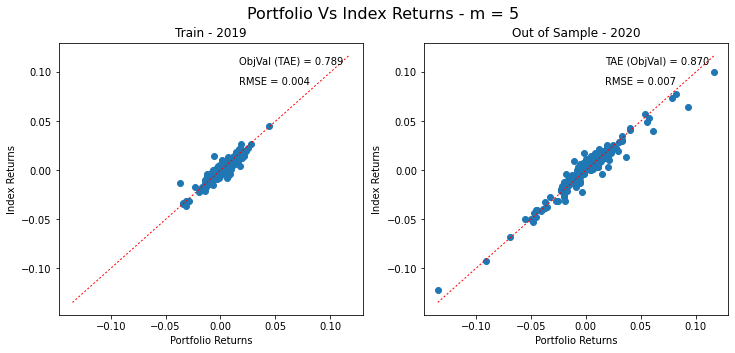

In [20]:
import matplotlib.pyplot as plt

m = 5

min_d = min(returns_train_1[f'm_{m}'].min(),returns_oos_1[f'm_{m}'].min())
max_d = max(returns_train_1[f'm_{m}'].max(),returns_oos_1[f'm_{m}'].max())
txt1 = results_1[results_1['m']==m]['objVal_train'].values[0]
txt2 = results_1[results_1['m']==m]['rmse_train'].values[0]
txt3 = results_1[results_1['m']==m]['objVal_oos'].values[0]
txt4 = results_1[results_1['m']==m]['rmse_oos'].values[0]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'Portfolio Vs Index Returns - m = {m}', fontsize=16)

#graph for 2019 showing portfolio returns and index returns
ax1.scatter(returns_train_1['m_5'],returns_train_1[col_index_name])
ax1.plot([min_d, max_d], [min_d, max_d], 'r-', lw=1,dashes=[2, 2])
ax1.text(max_d-.1, max_d-0.01, 'ObjVal (TAE) = {0:.3f}'.format(txt1), horizontalalignment='left')
ax1.text(max_d-.1, max_d-0.03, 'RMSE = {0:.3f}'.format(txt2), horizontalalignment='left')
ax1.set_ylabel('Index Returns')
ax1.set_xlabel('Portfolio Returns')
ax1.set_title('Train - 2019')

#graph for 2020 showing portfolio returns and index returns

ax2.scatter(returns_oos_1['m_5'],returns_oos_1[col_index_name])
ax2.plot([min_d, max_d], [min_d, max_d], 'r-', lw=1,dashes=[2, 2])
ax2.text(max_d-.1, max_d-0.01, 'TAE (ObjVal) = {0:.3f}'.format(txt3), horizontalalignment='left')
ax2.text(max_d-.1, max_d-0.03, 'RMSE = {0:.3f}'.format(txt4), horizontalalignment='left')
ax2.set_ylabel('Index Returns')
ax2.set_xlabel('Portfolio Returns')
ax2.set_title('Out of Sample - 2020')
plt.show()

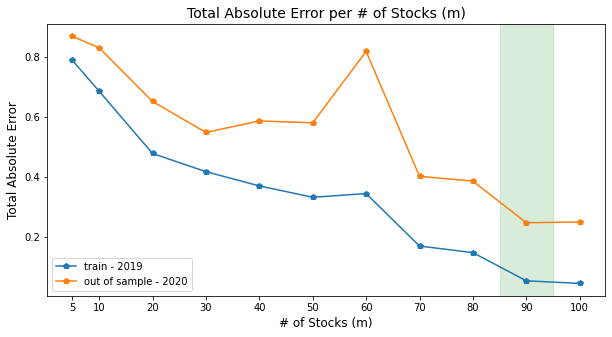

In [21]:
# Objective Val - 2steps Approach:

# graph comparing 2019 and 2020 Total absolute errors for different number of stocks
plt.figure(figsize=(10,5))
plt.plot(results_1['m'],results_1['objVal_train'], marker='p', label='train - 2019')
plt.plot(results_1['m'],results_1['objVal_oos'], marker='p', label='out of sample - 2020')
plt.xticks(results_1['m'].tolist())
plt.axvspan(85, 95, color='g', alpha=0.15)
plt.title('Total Absolute Error per # of Stocks (m)', fontsize=14)
plt.ylabel('Total Absolute Error', fontsize=12)
plt.xlabel('# of Stocks (m)', fontsize=12)
plt.legend()
plt.show()

## Analysis
MIP Approach

In [22]:
# Data
results_2 = pd.read_csv('02_1_results_MIP_approach.csv')
returns_train_2 = pd.read_csv('02_2_returns_MIP_train_portfolios.csv')
returns_oos_2 = pd.read_csv('02_3_returns_MIP_oos_portfolios.csv')
weights_2 = pd.read_csv('02_4_weights_MIP_approach.csv', index_col=0)

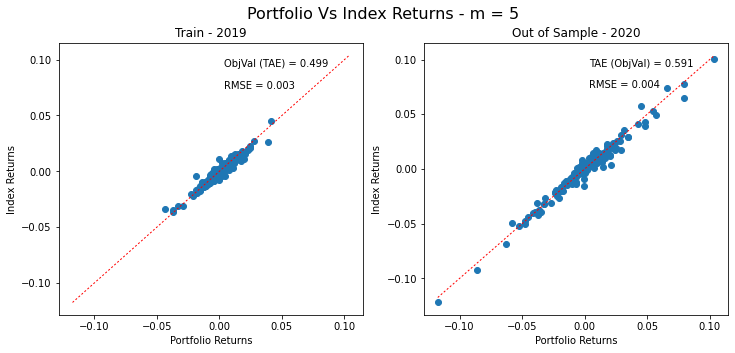

In [23]:
import matplotlib.pyplot as plt

m = 5

min_d = min(returns_train_2[f'm_{m}'].min(),returns_oos_2[f'm_{m}'].min())
max_d = max(returns_train_2[f'm_{m}'].max(),returns_oos_2[f'm_{m}'].max())
txt1 = results_2[results_2['m']==m]['objVal_train'].values[0]
txt2 = results_2[results_2['m']==m]['rmse_train'].values[0]
txt3 = results_2[results_2['m']==m]['objVal_oos'].values[0]
txt4 = results_2[results_2['m']==m]['rmse_oos'].values[0]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle(f'Portfolio Vs Index Returns - m = {m}', fontsize=16)

#graph for 2019 showing portfolio returns and index returns

ax1.scatter(returns_train_2['m_5'],returns_train_2[col_index_name])
ax1.plot([min_d, max_d], [min_d, max_d], 'r-', lw=1,dashes=[2, 2])
ax1.text(max_d-.1, max_d-0.01, 'ObjVal (TAE) = {0:.3f}'.format(txt1), horizontalalignment='left')
ax1.text(max_d-.1, max_d-0.03, 'RMSE = {0:.3f}'.format(txt2), horizontalalignment='left')
ax1.set_ylabel('Index Returns')
ax1.set_xlabel('Portfolio Returns')
ax1.set_title('Train - 2019')

#graph for 2020 showing portfolio returns and index returns

ax2.scatter(returns_oos_2['m_5'],returns_oos_2[col_index_name])
ax2.plot([min_d, max_d], [min_d, max_d], 'r-', lw=1,dashes=[2, 2])
ax2.text(max_d-.1, max_d-0.01, 'TAE (ObjVal) = {0:.3f}'.format(txt3), horizontalalignment='left')
ax2.text(max_d-.1, max_d-0.03, 'RMSE = {0:.3f}'.format(txt4), horizontalalignment='left')
ax2.set_ylabel('Index Returns')
ax2.set_xlabel('Portfolio Returns')
ax2.set_title('Out of Sample - 2020')
plt.show()

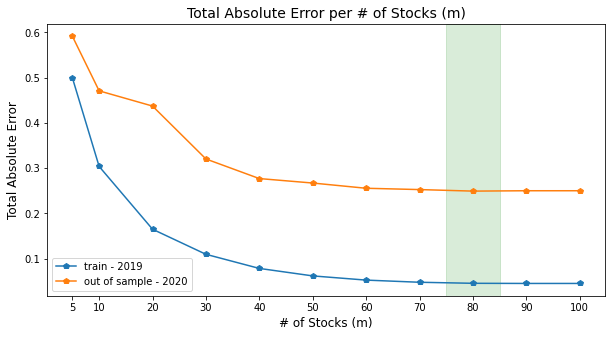

In [24]:
# Objective Val - MIP Approach: 

# graph comparing 2019 and 2020 Total absolute errors for different number of stocks
plt.figure(figsize=(10,5))
plt.plot(results_2['m'],results_2['objVal_train'], marker='p', label='train - 2019')
plt.plot(results_2['m'],results_2['objVal_oos'], marker='p', label='out of sample - 2020')
plt.xticks(results_2['m'].tolist())
plt.axvspan(75, 85, color='g', alpha=0.15)
plt.title('Total Absolute Error per # of Stocks (m)', fontsize=14)
plt.ylabel('Total Absolute Error', fontsize=12)
plt.xlabel('# of Stocks (m)', fontsize=12)
plt.legend()
plt.show()

## Comparison First Approach Vs Second Approach

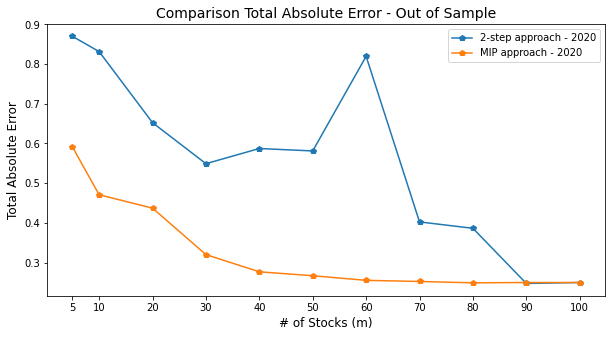

In [25]:
# Comparison: 2-step Approach Vs MIP Approach: 
plt.figure(figsize=(10,5))
plt.plot(results_1['m'],results_1['objVal_oos'], marker='p', label='2-step approach - 2020')
plt.plot(results_2['m'],results_2['objVal_oos'], marker='p', label='MIP approach - 2020')
plt.xticks(results_2['m'].tolist())
#plt.axvspan(75, 85, color='g', alpha=0.15)
plt.title('Comparison Total Absolute Error - Out of Sample', fontsize=14)
plt.ylabel('Total Absolute Error', fontsize=12)
plt.xlabel('# of Stocks (m)', fontsize=12)
plt.legend()
plt.show()

### Average Absolute Error per Quintiles - 2019 and 2020 (Analysis)

In [26]:
# df_ret = returns_train_1

# ret_tmp = df_ret.copy()
# ret_tmp['d_50'] = abs(df_ret['NDX']-returns_oos_1['m_50'])
# ret_tmp['q_50'] = pd.qcut(ret_tmp['d_50'], 5, labels=[1,2,3,4,5])
# ret_tmp_1 = ret_tmp.groupby('q_50')['d_50'].mean()
# #ret_tmp_1

# ret_tmp = df_ret.copy()
# ret_tmp['d_60'] = abs(df_ret['NDX']-returns_oos_1['m_60'])
# ret_tmp['q_60'] = pd.qcut(ret_tmp['d_60'], 5, labels=[1,2,3,4,5])
# ret_tmp_2 = ret_tmp.groupby('q_60')['d_60'].mean()
# #ret_tmp_2

# ret_tmp = df_ret.copy()
# ret_tmp['d_70'] = abs(df_ret['NDX']-returns_oos_1['m_70'])
# ret_tmp['q_70'] = pd.qcut(ret_tmp['d_70'], 5, labels=[1,2,3,4,5])
# ret_tmp_3 = ret_tmp.groupby('q_70')['d_70'].mean()
# #ret_tmp_3

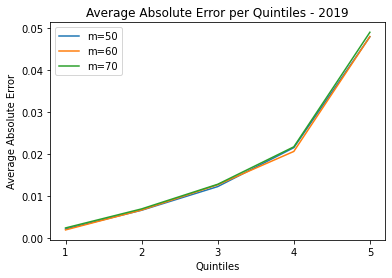

In [27]:
# plt.title('Average Absolute Error per Quintiles - 2019')
# plt.plot(ret_tmp_1, label = 'm=50')
# plt.plot(ret_tmp_2, label = 'm=60')
# plt.plot(ret_tmp_3, label = 'm=70')
# plt.ylabel('Average Absolute Error')
# plt.xlabel('Quintiles')
# plt.xticks([1,2,3,4,5])
# plt.legend()
# plt.show()

In [28]:
# df_ret = returns_oos_1

# ret_tmp = df_ret.copy()
# ret_tmp['d_50'] = abs(df_ret['NDX']-returns_oos_1['m_50'])
# ret_tmp['q_50'] = pd.qcut(ret_tmp['d_50'], 5, labels=[1,2,3,4,5])
# ret_tmp_1 = ret_tmp.groupby('q_50')['d_50'].mean()
# #ret_tmp_1

# ret_tmp = df_ret.copy()
# ret_tmp['d_60'] = abs(df_ret['NDX']-returns_oos_1['m_60'])
# ret_tmp['q_60'] = pd.qcut(ret_tmp['d_60'], 5, labels=[1,2,3,4,5])
# ret_tmp_2 = ret_tmp.groupby('q_60')['d_60'].mean()
# #ret_tmp_2

# ret_tmp = df_ret.copy()
# ret_tmp['d_70'] = abs(df_ret['NDX']-returns_oos_1['m_70'])
# ret_tmp['q_70'] = pd.qcut(ret_tmp['d_70'], 5, labels=[1,2,3,4,5])
# ret_tmp_3 = ret_tmp.groupby('q_70')['d_70'].mean()
# #ret_tmp_3

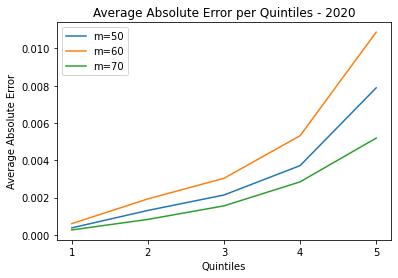

In [29]:
# plt.title('Average Absolute Error per Quintiles - 2020')
# plt.plot(ret_tmp_1, label = 'm=50')
# plt.plot(ret_tmp_2, label = 'm=60')
# plt.plot(ret_tmp_3, label = 'm=70')
# plt.ylabel('Average Absolute Error')
# plt.xlabel('Quintiles')
# plt.xticks([1,2,3,4,5])
# plt.legend()
# plt.show()